# Potato Disease Classification Model Training

- Data Sets From: Kaggele (Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village)
- Project Turtorial by Codebasic(Youtube Channel)

### Import Required Packages

In [110]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### Background Setup

In [111]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [112]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [113]:
# Stright showing all folder's name
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [114]:
len(dataset)

68

In [115]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 2 0 0 1 1 1 0 1 2 1 0 1]


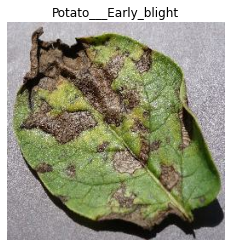

In [116]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

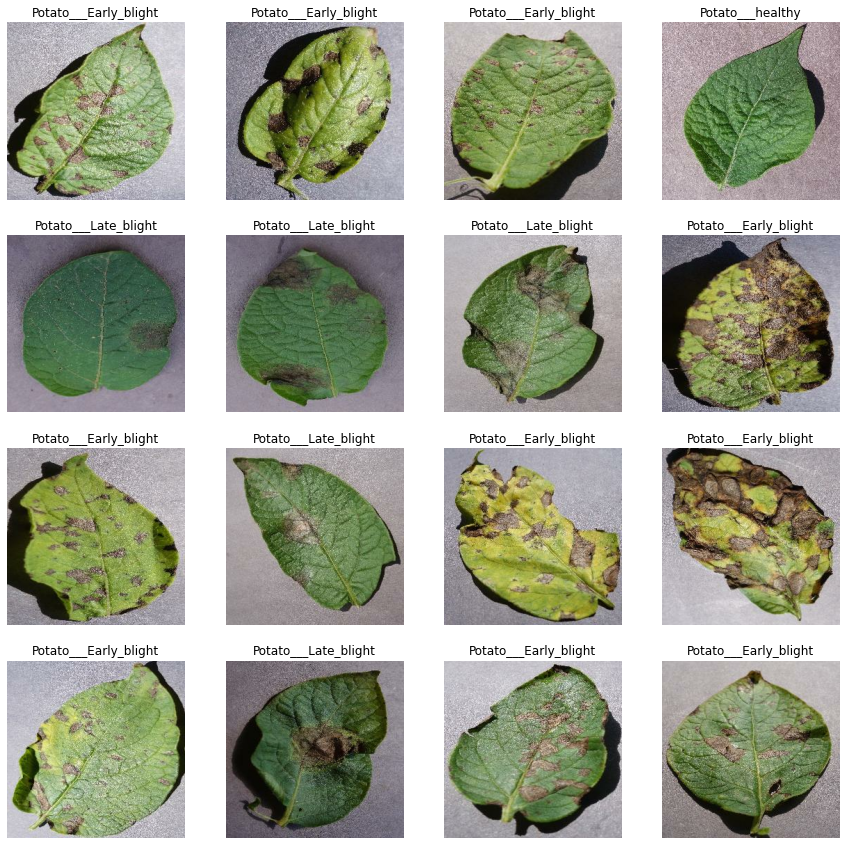

In [117]:
plt.figure(figsize = (15, 15))
for image_batch, label_batch in dataset.take(1):
    for i in range(16):
        plt.subplot(4, 4, i +1 )
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [118]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [119]:
train_ds = dataset.take(54)
len(train_ds)

54

In [120]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [121]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [122]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [123]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [124]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [125]:
# len(train_ds)
# len(val_ds)
len(test_ds)

8

In [126]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size =  tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size =  tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [127]:
# train_ds
# val_ds
test_ds

<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

### Building the Model:

In [128]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [129]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [130]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [131]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [132]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (32, 30, 30, 64)        

In [133]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [134]:
train_ds

<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [135]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 47s 874ms/step - loss: 0.8924 - accuracy: 0.5220 - val_loss: 0.8836 - val_accuracy: 0.5729
Epoch 2/50
54/54 [==============================] - 48s 883ms/step - loss: 0.6478 - accuracy: 0.7297 - val_loss: 0.5035 - val_accuracy: 0.8021
Epoch 3/50
54/54 [==============================] - 48s 888ms/step - loss: 0.4660 - accuracy: 0.8044 - val_loss: 0.9051 - val_accuracy: 0.6562
Epoch 4/50
54/54 [==============================] - 47s 877ms/step - loss: 0.3176 - accuracy: 0.8704 - val_loss: 0.4417 - val_accuracy: 0.8385
Epoch 5/50
54/54 [==============================] - 49s 905ms/step - loss: 0.2356 - accuracy: 0.9115 - val_loss: 0.3323 - val_accuracy: 0.8854
Epoch 6/50
54/54 [==============================] - 50s 924ms/step - loss: 0.2372 - accuracy: 0.9091 - val_loss: 0.3269 - val_accuracy: 0.8802
Epoch 7/50
54/54 [==============================] - 52s 954ms/step - loss: 0.2523 - accuracy: 0.8976 - val_loss: 0.1984 - val_accuracy: 0.9323

In [136]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 138ms/step - loss: 0.0601 - accuracy: 0.9766


In [137]:
scores

[0.0601443350315094, 0.9765625]

### Data Visualization:

In [138]:
history

In [139]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [140]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [141]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

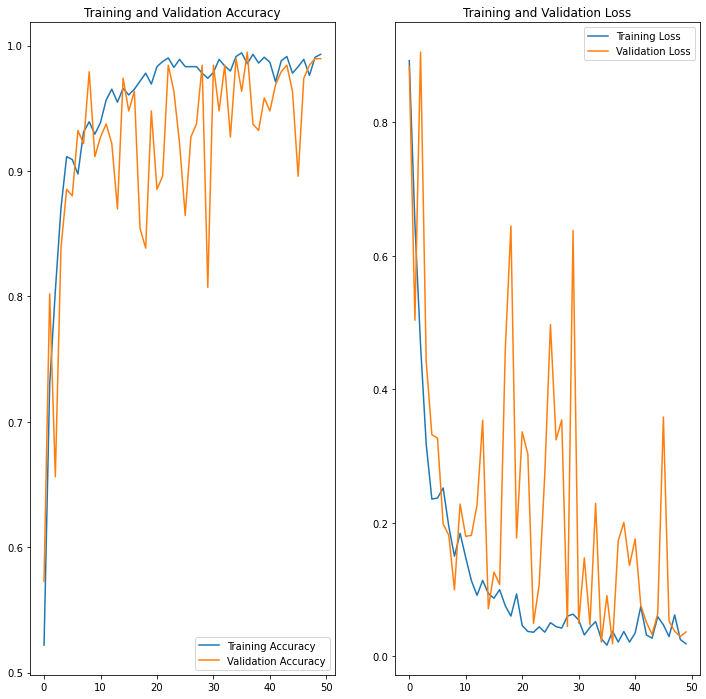

In [142]:
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Prediction and Sample Image:

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


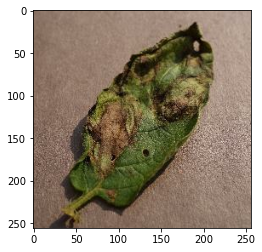

In [143]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1): # Randome choose one of the dataset
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [144]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

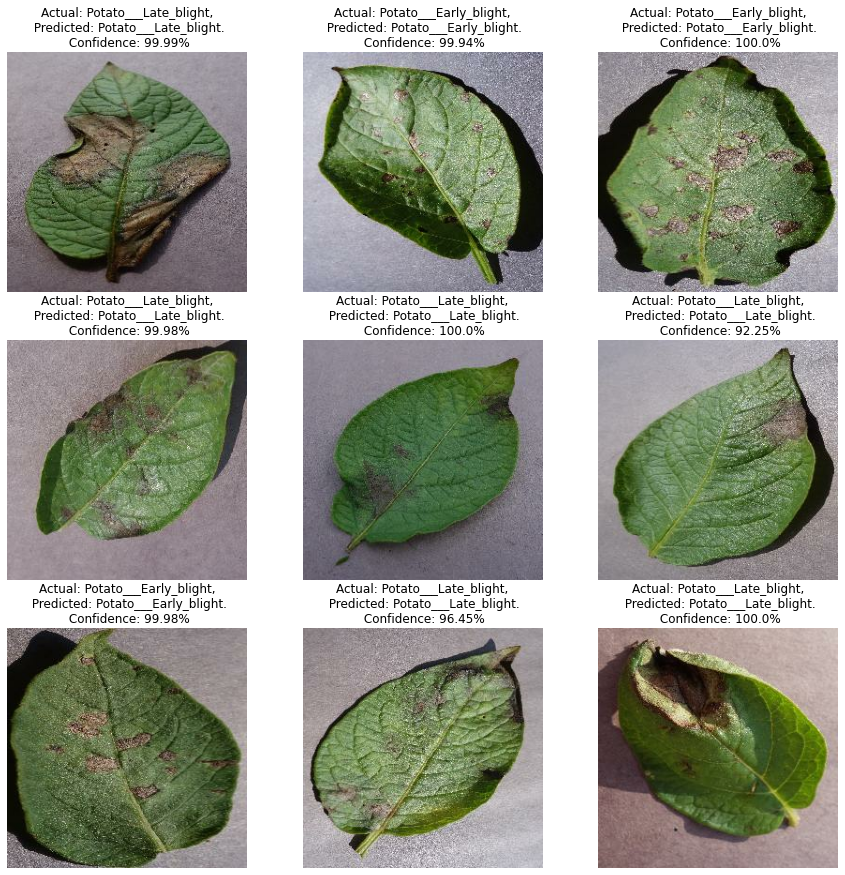

In [148]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [151]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets
